In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the data (As there are more than 60 lakhs of records we are only taking a subset of that which is 50000 rows) :-
df = pd.read_csv(r"C:\Users\Amuthan\Datasets & Notebooks\CSV_files\Money Laundering.csv.csv", nrows=50000)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(50000, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

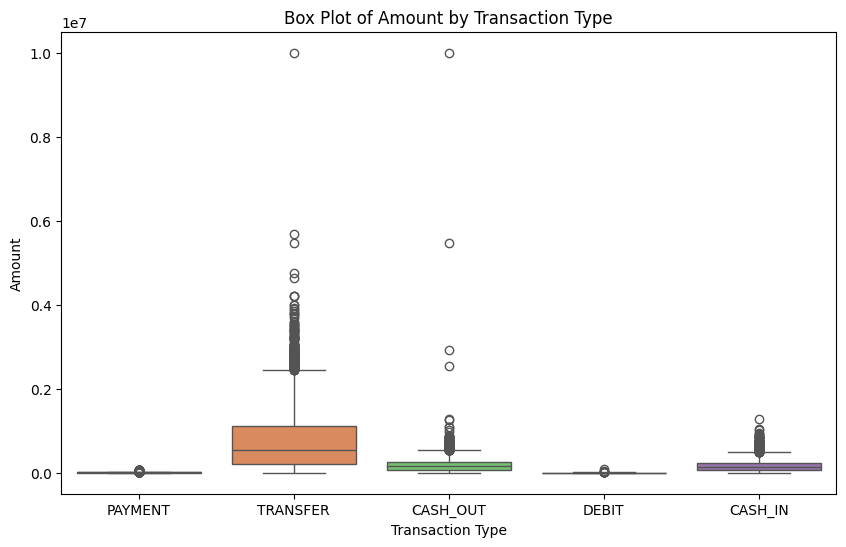

In [6]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'type', y = 'amount', data = df, palette = 'muted')
plt.title('Box Plot of Amount by Transaction Type')
plt.ylabel('Amount')
plt.xlabel('Transaction Type')
plt.show()

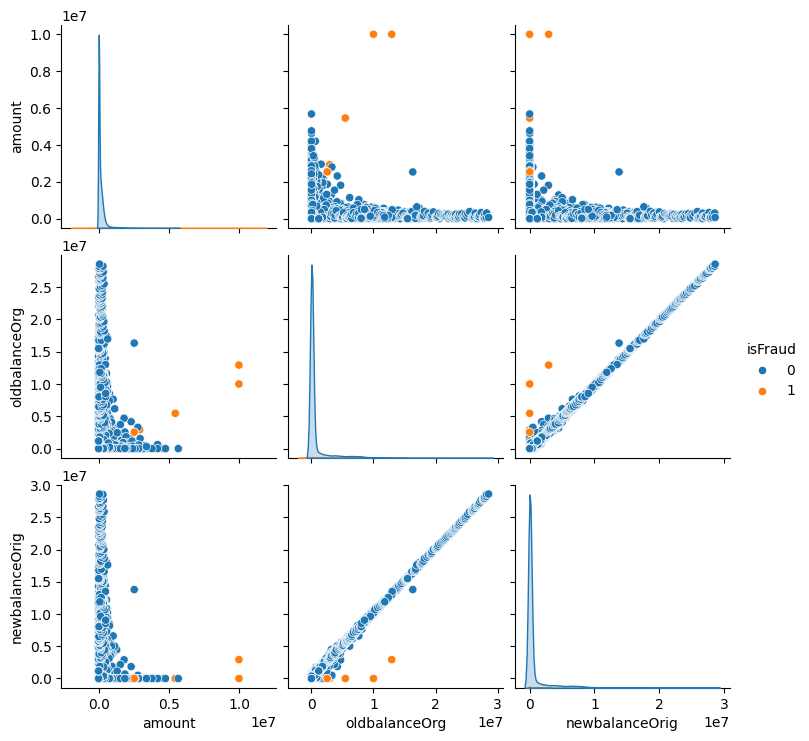

In [7]:
sns.pairplot(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud', 'type']], hue='isFraud')
plt.show()

# Feature Engineering :-

In [8]:
def feature_engineering(data):
    # Combine balance change flags into a single column
    data['orig_balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg']
    data['dest_balance_change'] = data['newbalanceDest'] - data['oldbalanceDest']
    
    balance_change_threshold = 50000  # Example threshold
    data['significant_balance_change'] = ((data['orig_balance_change'].abs() > balance_change_threshold) | 
        (data['dest_balance_change'].abs() > balance_change_threshold)).astype(int)
    
    # Drop intermediate balance change columns
    data.drop(['orig_balance_change', 'dest_balance_change'], axis=1, inplace=True)
    
    # Surge indicator for large transaction amounts
    surge_threshold = 450000  # Example threshold
    data['surge'] = (data['amount'] > surge_threshold).astype(int)
    
    # Combine frequency flags into a single column
    sender_freq = data['nameOrig'].map(data['nameOrig'].value_counts())
    receiver_freq = data['nameDest'].map(data['nameDest'].value_counts())
    
    high_freq_threshold = 20  # Example threshold for high frequency
    data['high_freq_transaction'] = (
        (sender_freq > high_freq_threshold) | 
        (receiver_freq > high_freq_threshold)).astype(int)
    
    # Merchant flag
    data['merchant'] = data['nameDest'].str.startswith('M').astype(int)
    
    return data

df = feature_engineering(df)

# Data Pre-processing :-

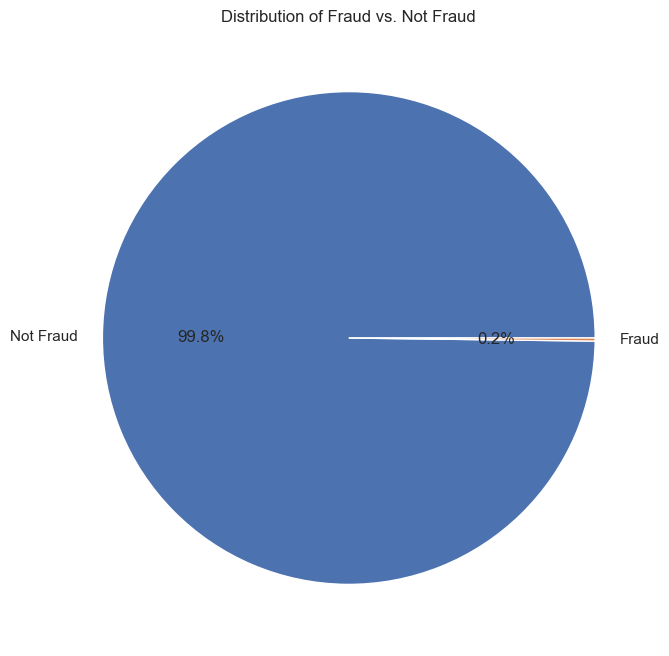

In [9]:
# Create a copy of the DataFrame
df1 = df.copy()

# Calculate the value counts for the target variable
fraud_counts = df1['isFraud'].value_counts()

# Setting the Seaborn style
sns.set(style = "whitegrid")

# Plotting the pie chart
plt.figure(figsize = (8, 8))
plt.pie(fraud_counts, labels = ['Not Fraud', 'Fraud'], autopct = '%1.1f%%', colors = sns.color_palette("deep"))
plt.title('Distribution of Fraud vs. Not Fraud')
plt.show()

# Solving Class Imbalances :-

In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df1[df1.isFraud == 0]
df_minority = df1[df1.isFraud == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace = True,    # Sample with replacement
                                 n_samples = len(df_majority), # Match number in majority class
                                 random_state = 123) # Reproducible results

# Combine majority class with upsampled minority class
df1 = pd.concat([df_majority, df_minority_upsampled])

# Balanced Classes :-

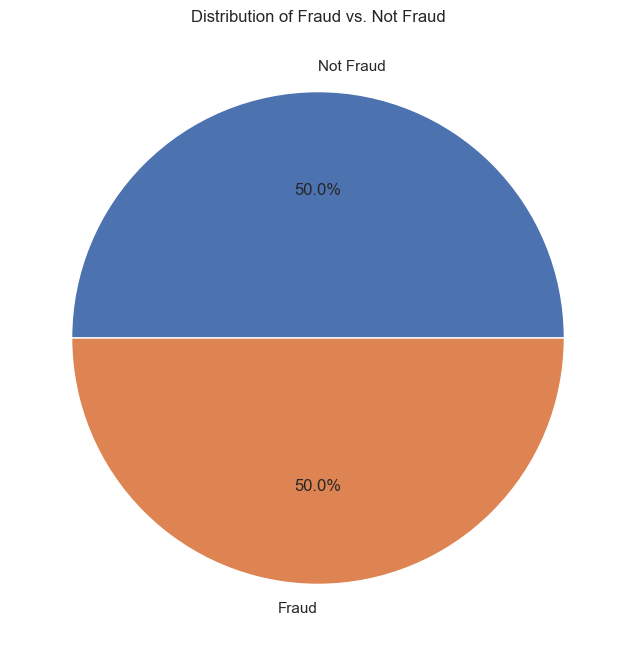

In [11]:
fraud_counts = df1['isFraud'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', colors=sns.color_palette("deep"))
plt.title('Distribution of Fraud vs. Not Fraud')
plt.show()

# Encoding :-

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Onehot encoding
encoder = OneHotEncoder(sparse_output = False, drop = 'first')
type_encoded = encoder.fit_transform(df1[['type']])
type_encoded_df = pd.DataFrame(type_encoded, columns = encoder.get_feature_names_out(['type']))
df1.reset_index(drop = True, inplace = True)
type_encoded_df.reset_index(drop = True, inplace = True)
df1 = pd.concat([df1, type_encoded_df], axis = 1)
df1.drop(['type'], axis = 1, inplace = True)

In [13]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding
label_encoder = LabelEncoder()

# Fit the encoder on the entire dataset
df1['nameOrig_encoded'] = label_encoder.fit_transform(df1['nameOrig'])
df1['nameDest_encoded'] = label_encoder.fit_transform(df1['nameDest'])

# Drop the original columns if desired
df1.drop(['nameOrig', 'nameDest'], axis = 1, inplace = True)

In [14]:
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,significant_balance_change,surge,high_freq_transaction,merchant,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameOrig_encoded,nameDest_encoded
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,5827,17577
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,17147,18288
2,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,27000,9098
3,1,7817.71,53860.0,46042.29,0.0,0.0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,47393,23635
4,1,7107.77,183195.0,176087.23,0.0,0.0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,14092,21762


In [15]:
df2 = df1.copy()
X = df2.drop('isFraud',axis = 1)
y = df2['isFraud']

# Train Test split :-

In [16]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 111)

# Standardization :-

In [17]:
from sklearn.preprocessing import StandardScaler

# Standardization
col_names =['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] = features_test

In [18]:
#Dropping unnecessary columns
X_train = X_train.drop(['isFlaggedFraud'],axis=1)
X_train = X_train.reset_index(drop=True)

X_test = X_test.drop(['isFlaggedFraud'],axis=1)
X_test = X_test.reset_index(drop=True)

# Model :-

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#creating the objects
lr = LogisticRegression(solver = 'liblinear',random_state=1)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 1)
cv_dict = {0: 'Logistic Regression', 1: 'KNN', 2: 'Random Forest'}
cv_models = [lr,knn,rf]


for i,model in enumerate(cv_models):
    print(f"{cv_dict[i]} Test Accuracy: {cross_val_score(model, X_train, y_train, cv = 10, scoring ='accuracy').mean()}")

Logistic Regression Test Accuracy: 0.8892642427712568
KNN Test Accuracy: 0.995190380761523
Random Forest Test Accuracy: 0.9999141139421701


# Hyper-parameter Tuning :-

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_rf, cv = 10, n_jobs = -1, verbose = 1)

rf_grid_search.fit(X_train, y_train)

print(rf_grid_search.best_estimator_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
RandomForestClassifier(n_estimators=200, random_state=1)


# Evaluation :-

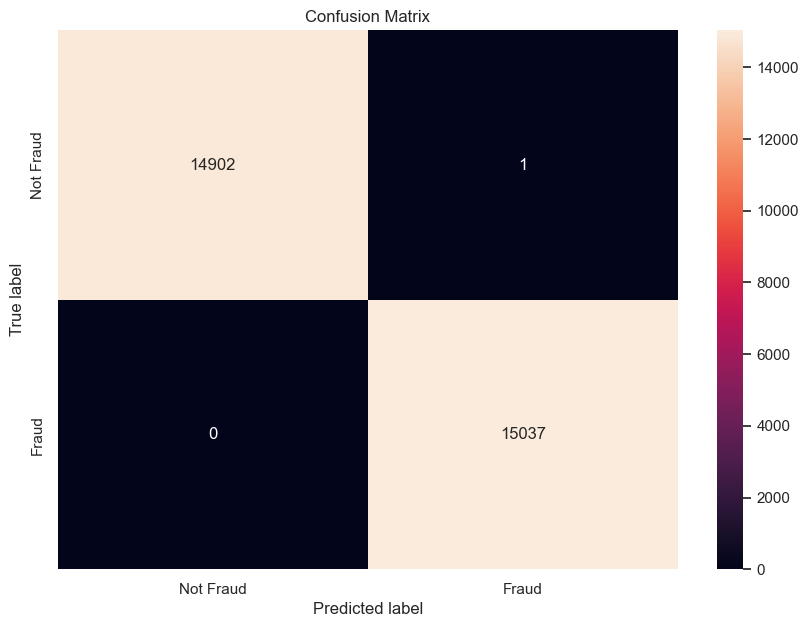

[[14902     1]
 [    0 15037]]


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Predict with the selected best parameter
y_pred = rf_grid_search.predict(X_test)

#Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names for the confusion matrix
class_names = ['Not Fraud', 'Fraud']

# Plotting the confusion matrix
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot the confusion matrix
print(cm)

In [25]:
#Classification metrics
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     14903
       Fraud       1.00      1.00      1.00     15037

    accuracy                           1.00     29940
   macro avg       1.00      1.00      1.00     29940
weighted avg       1.00      1.00      1.00     29940

